# Tacking Point Estimation

In [1]:
import jax.numpy as jnp
from jax import Array
from jax import vmap

import matplotlib.pyplot as plt

from abc import ABC

from geometry.lorentz_finsler.manifolds import RiemannianNavigation
from geometry.riemannian.manifolds import nEllipsoid, nSphere, T2

from geometry.lorentz_finsler.manifolds import LorentzFinslerManifold
from geometry.lorentz_finsler.geodesics import GEORCE as GEORCE, JAXOptimization
from geometry.lorentz_finsler.tacking import GEORCE as GEORCE_TACK
from geometry.lorentz_finsler.tacking import JAXOptimization as JAX_TACK

## Tacking with Straight Line Finsler Geometries

### Defining Finsler Geometry

In [2]:
class EllipticFinsler(ABC):
    def __init__(self,
                 c1=1.0, 
                 c2=1.0,
                 a=1.0,
                 b=1.0,
                 theta=jnp.pi/4
                )->None:
        
        self.c1 = c1
        self.c2 = c2
        self.a = a
        self.b = b
        self.theta = theta
        
    def __call__(self, t, x, v):
        
        c1 = self.c1(t)
        c2 = self.c2(t)
        a = self.a(t)
        b = self.b(t)
        theta = self.theta(t)
        
        x,y = v[0], v[1]
        
        a2 = a**2
        b2 = b**2
        a4 = a**4
        b4 = b**4
        c12 = c1**2
        c22 = c2**2

        f = (-a2*c2*(x*jnp.sin(theta)+y*jnp.cos(theta))-\
             b2*c1*(x*jnp.cos(theta)-y*jnp.sin(theta))+\
             (a4*b2*(x*jnp.sin(theta)+y*jnp.cos(theta))**2+\
              a2*b4*(x*jnp.cos(theta)-y*jnp.sin(theta))**2-\
              a2*b2*c12*(x*jnp.sin(theta)+y*jnp.cos(theta))**2+\
              2*a2*b2*c1*c2*(x*jnp.cos(theta)-y*jnp.sin(theta))*(x*jnp.sin(theta)+y*jnp.cos(theta))-\
              a2*b2*c22*(x*jnp.cos(theta)-y*jnp.sin(theta))**2)**(1/2))/(a2*b2-a2*c22-b2*c12)
        
        return f

In [3]:
rho=lambda t: (3+jnp.cos(t))*0.5
phi= lambda t: 0.5*jnp.pi+t*jnp.pi/10
theta = lambda t: t*jnp.pi/6
a= lambda t: 3+jnp.sin(t*jnp.pi/4)
b= lambda t: 4
c1 = lambda t: -rho(t)*jnp.cos(phi(t))
c2 = lambda t: -rho(t)*jnp.sin(phi(t))

Falpha = EllipticFinsler(c1=c1,c2=c2, a=a,b=b,theta=theta)
Malpha = LorentzFinslerManifold(F=Falpha)

In [4]:
rho=lambda t: 3*0.5
phi= lambda t: 0.5*jnp.pi+t*jnp.pi/5
theta = lambda t: 0
a= lambda t: 2
b= lambda t: 2
c1 = lambda t: -rho(t)*jnp.cos(phi(t))
c2 = lambda t: -rho(t)*jnp.sin(phi(t))

Fbeta = EllipticFinsler(c1=c1,c2=c2, a=a,b=b,theta=theta)
Mbeta = LorentzFinslerManifold(F=Fbeta)

### Estimating Tack Points

In [5]:
z0 = jnp.array([0.,0.])
zT = jnp.array([2.,8.])

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [6]:
Geodesic = GEORCE(Mbeta, max_iter=1000, tol=1e-4, line_search_params={'rho':0.5}, obj_method="finsler")

In [7]:
test = Geodesic(z0,zT)

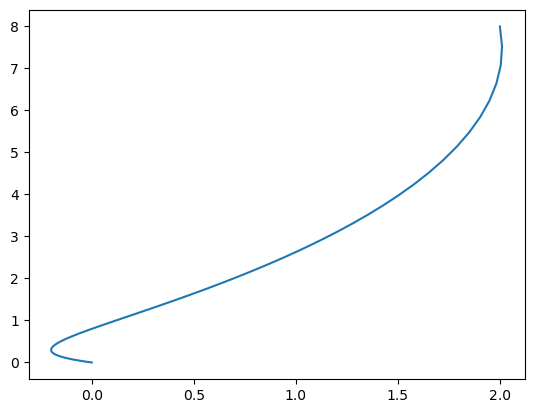

In [8]:
plt.plot(test[1][:,0], test[1][:,1])

In [13]:
tack_metrics = [Malpha,Mbeta,Malpha,Mbeta,Malpha]
TackOpt = JAX_TACK(tack_metrics, lr_rate=0.01, max_iter=100000, T=100,tol=1e-4)
tack_metrics2 = [Mbeta,Malpha,Mbeta,Malpha,Mbeta]
TackOpt2 = JAX_TACK(tack_metrics2, lr_rate=0.01, max_iter=100000, T=100,tol=1e-4)
Geodesic = GEORCE(Malpha, max_iter=1000, tol=1e-4, line_search_params={'rho':0.5})

In [14]:
zt1_tack = TackOpt2(z0,zT, N_tacks=1)

In [15]:
zt1_tack[-1]

Array(100000, dtype=int32, weak_type=True)

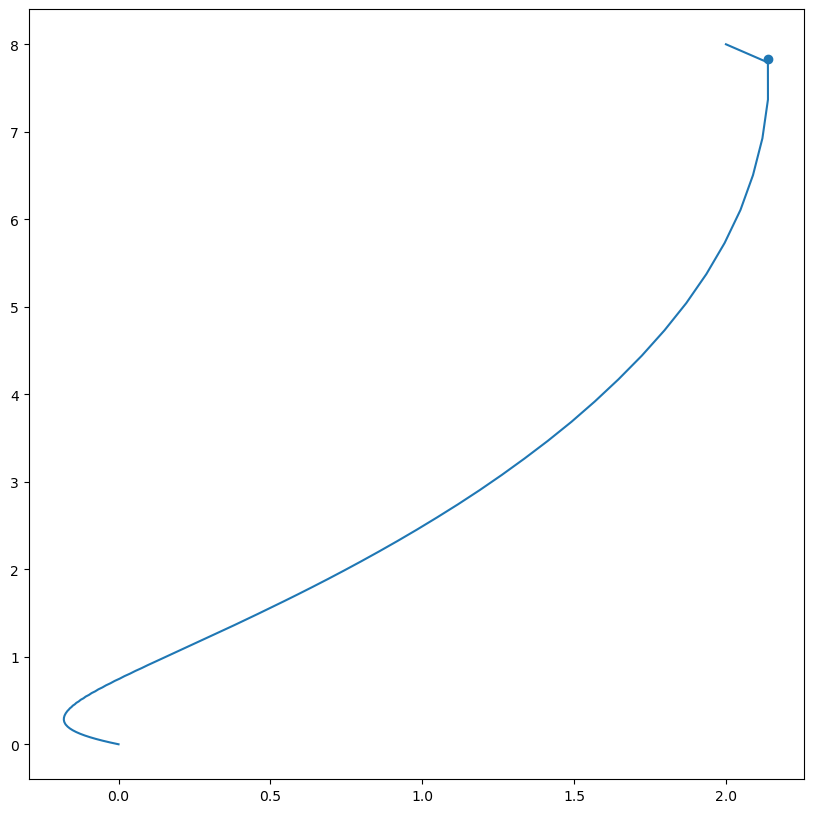

In [16]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(zt1_tack[1][100,0], zt1_tack[1][100,1])
ax.plot(zt1_tack[1][:,0], zt1_tack[1][:,1])

In [13]:
zt1_indicatrix1 = Malpha.indicatrix(zt1_tack[50], grid=jnp.linspace(-5,5,1000), eps=1e-6)+zt1_tack[50]
zt1_indicatrix2 = Mbeta.indicatrix(zt1_tack[150], grid=jnp.linspace(-5,5,1000), eps=1e-6)+zt1_tack[150]
zt2_indicatrix1 = Mbeta.indicatrix(zt2_tack[50], grid=jnp.linspace(-5,5,1000), eps=1e-6)+zt2_tack[50]
zt2_indicatrix2 = Malpha.indicatrix(zt2_tack[150], grid=jnp.linspace(-5,5,1000), eps=1e-6)+zt2_tack[150]

IndexError: tuple index out of range

### Plotting Tacks

TypeError: tuple indices must be integers or slices, not tuple

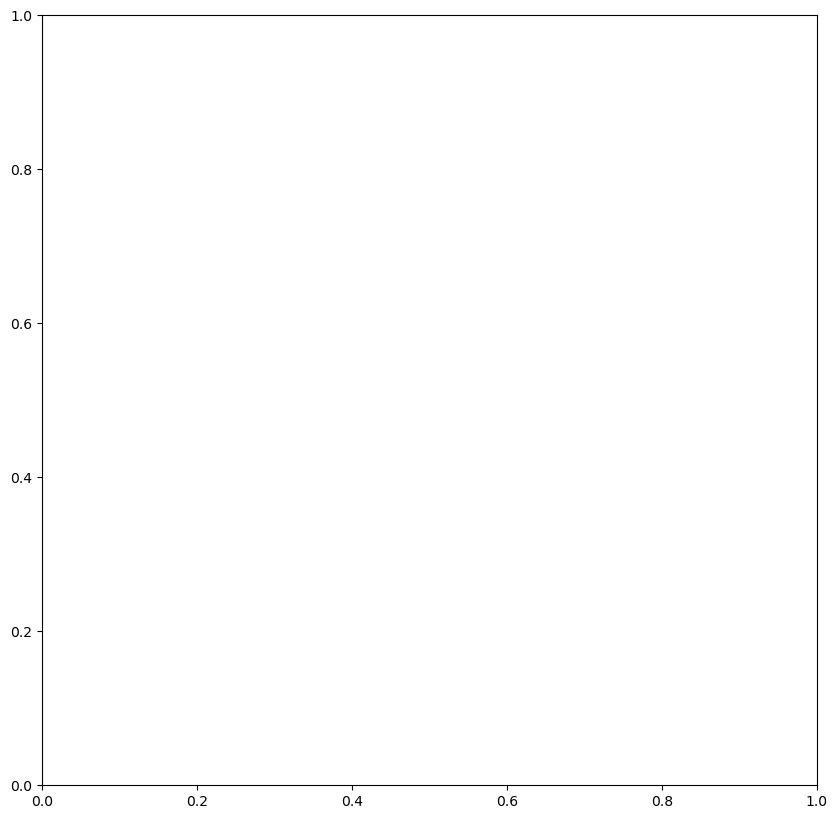

In [16]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(zt1_tack[:,0], zt1_tack[:,1], color='red')
ax.plot(zt2_indicatrix1[:,0], zt2_indicatrix1[:,1], color='black', linestyle='dashed')
ax.plot(zt1_indicatrix2[:,0], zt1_indicatrix2[:,1], color='black', linestyle='dashed')
ax.plot(zt2_indicatrix2[:,0], zt2_indicatrix2[:,1], color='black', linestyle='dashed')
ax.plot(zt1_indicatrix1[:,0], zt1_indicatrix1[:,1], color='black', linestyle='dashed')
ax.scatter(zt1_tack[50][0], zt1_tack[50][1], color='black')
ax.scatter(zt1_tack[150][0], zt1_tack[150][1], color='black')
ax.scatter(zt2_tack[50][0], zt2_tack[50][1], color='black')
ax.scatter(zt2_tack[150][0], zt2_tack[150][1], color='black')
ax.scatter(zt1_tack[100,0], zt1_tack[100,1], color='red')
ax.plot(zt2_tack[:,0], zt2_tack[:,1], color='blue')
ax.scatter(zt2_tack[100,0], zt2_tack[100,1], color='blue')
ax.plot(zt[:,0], zt[:,1], color='green')
ax.scatter(z0[0], z0[1], color='black')
ax.scatter(zT[0], zT[1], color='black')
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
ax.grid(True)

plt.show()

## Tacking for Riemannian Navigation

### Defining Finsler Geometry

In [43]:
def force_fun1(t,z, M):
    
    val = jnp.sin(z)
    
    val2 = jnp.sqrt(jnp.einsum('i,ij,j->', val, M.G(z), val))
    
    return val/val2#jnp.cos(z)*val/val2

In [44]:
def force_fun2(t, z, M):
    
    val = jnp.cos(z)
    
    val2 = jnp.sqrt(jnp.einsum('i,ij,j->', val, M.G(z), val))
    
    return val/val2#jnp.sin(z)*val/val2

In [45]:
v0 = 1.5

In [46]:
RM = nSphere(dim=2)

z0 = -jnp.linspace(0,1,2)
zT = jnp.ones(2, dtype=jnp.float32)

s2_x0 = RM.f(z0)
s2_xT = RM.f(zT)

In [47]:
M1 = RiemannianNavigation(RM=RM,
                         force_fun=lambda t,z: force_fun1(t, z, RM),
                         v0=v0,
                        )

In [48]:
M2 = RiemannianNavigation(RM=RM,
                         force_fun=lambda t, z: force_fun2(t, z, RM),
                         v0=v0,
                        )

### Tack Point Estimation

In [58]:
TackOpt = GEORCE_TACK([M1,M1], max_iter=1000, T=100,tol=1e-4, line_search_params={'rho':0.5})
#TackOpt = JAX_TACK([M1,M1], lr_rate=0.01, max_iter=100000, T=100,tol=1e-4)
Geodesic = GEORCE(M1, max_iter=1000, T=200, tol=1e-4, line_search_params={'rho':0.5})

In [59]:
zt_path = TackOpt(z0,zT, N_tacks=1)
zt_single = Geodesic(z0,zT)

In [60]:
zt_single[0][-1]

Array(1.809347, dtype=float32)

In [61]:
zt_path[0].reshape(-1)

Array([0.02087464, 0.04191782, 0.06312929, 0.08450859, 0.10605537,
       0.1277688 , 0.14964816, 0.17169261, 0.19390102, 0.21627212,
       0.23880474, 0.26149732, 0.28434807, 0.3073552 , 0.33051687,
       0.35383052, 0.377294  , 0.4009045 , 0.42465922, 0.44855526,
       0.4725891 , 0.49675724, 0.52105594, 0.5454812 , 0.57002866,
       0.5946939 , 0.61947167, 0.64435726, 0.669345  , 0.69442904,
       0.7196034 , 0.74486184, 0.7701973 , 0.795603  , 0.82107127,
       0.8465944 , 0.8721643 , 0.89777267, 0.92341024, 0.9490681 ,
       0.97473663, 1.0004057 , 1.0260651 , 1.0517043 , 1.0773121 ,
       1.102877  , 1.1283875 , 1.1538312 , 1.1791962 , 1.2044696 ,
       1.2296385 , 1.2546896 , 1.2796096 , 1.3043852 , 1.3290024 ,
       1.3534473 , 1.3777065 , 1.401766  , 1.4256117 , 1.4492302 ,
       1.4726079 , 1.4957315 , 1.5185881 , 1.541165  , 1.5634506 ,
       1.5854329 , 1.6071011 , 1.6284451 , 1.6494554 , 1.6701233 ,
       1.6904411 , 1.710402  , 1.7300005 , 1.7492317 , 1.76809

In [62]:
zt_path[-1]

Array(1000, dtype=int32, weak_type=True)

In [63]:
zt_single[-1]

Array(11, dtype=int32, weak_type=True)

In [64]:
xt_path = vmap(RM.f)(zt_path[1])
xt_single = vmap(RM.f)(zt_single[1])

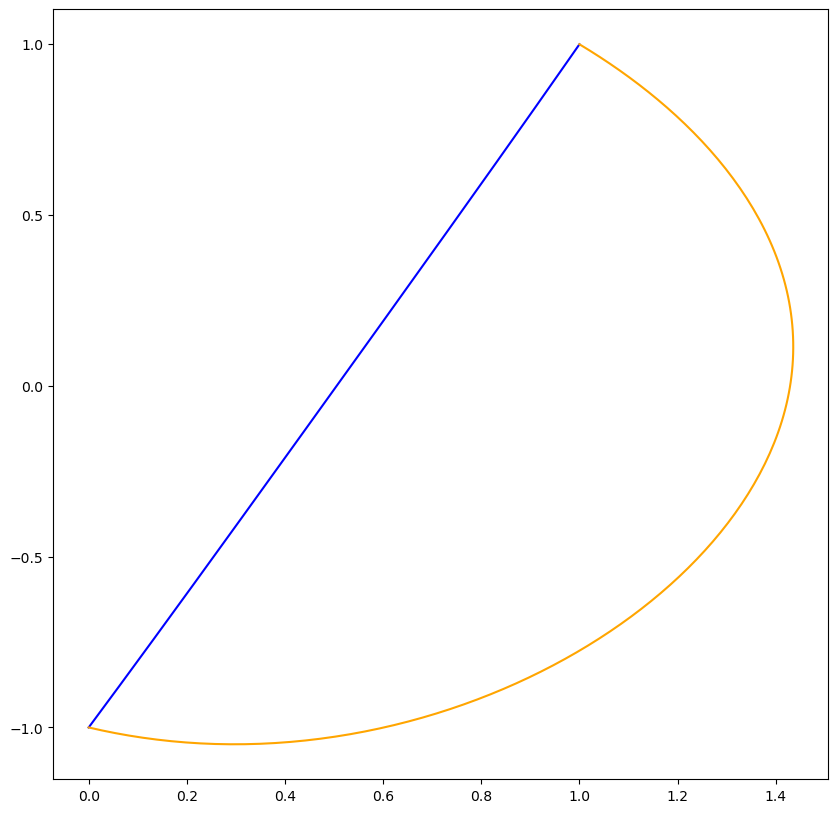

In [65]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
#ax.scatter(zt_path[1][100,0], zt_path[1][100,1])
ax.plot(zt_path[1][:,0], zt_path[1][:,1], color='blue')
ax.plot(zt_single[1][:,0], zt_single[1][:,1], color='orange')

### Plotting Tacks

In [14]:
class SpherePlot(ABC):
    def __init__(self, 
                 force_fun,
                ):
        
        self.M = nSphere(dim=2)
        self.force_fun = lambda t, z: force_fun(t, z, self.M)
        self.params = jnp.ones(2)

    def heat_map(self, X, Y, Z)->Array:
        
        z = vmap(lambda x,y,z: vmap(lambda x1,y1,z1: self.M.invf(jnp.stack((x1,y1,z1))))(x,y,z))(X,Y,Z)
        
        heat_map = vmap(lambda z1: vmap(lambda z: jnp.linalg.norm(self.force_fun(z)))(z1))(z)
        
        return heat_map
    
    def unit_direction(self, n_points:int=100)->Array:
        
        X,Y,Z = self.grid(n_points)
        
        z = vmap(lambda x,y,z: vmap(lambda x1,y1,z1: self.M.invf(jnp.stack((x1,y1,z1))))(x,y,z))(X,Y,Z)
        
        force = vmap(lambda z1: vmap(lambda z: jnp.dot(self.M.Jf(z), self.force_fun(z)))(z1))(z)
        
        return X,Y,Z,force
        
    def grid(self, n_points:int=100)->Array:
        
        theta = jnp.linspace(0.0, jnp.pi*1, n_points)
        phi   = jnp.linspace(0.0, jnp.pi*2, n_points)

        # Creating the coordinate grid for the unit sphere.
        x1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
        x2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
        x3 = jnp.outer(jnp.cos(theta), jnp.ones(n_points))
        
        return self.params[0]*x1,self.params[1]*x2,self.params[2]*x3
         

NameError: name 'force_fun1' is not defined

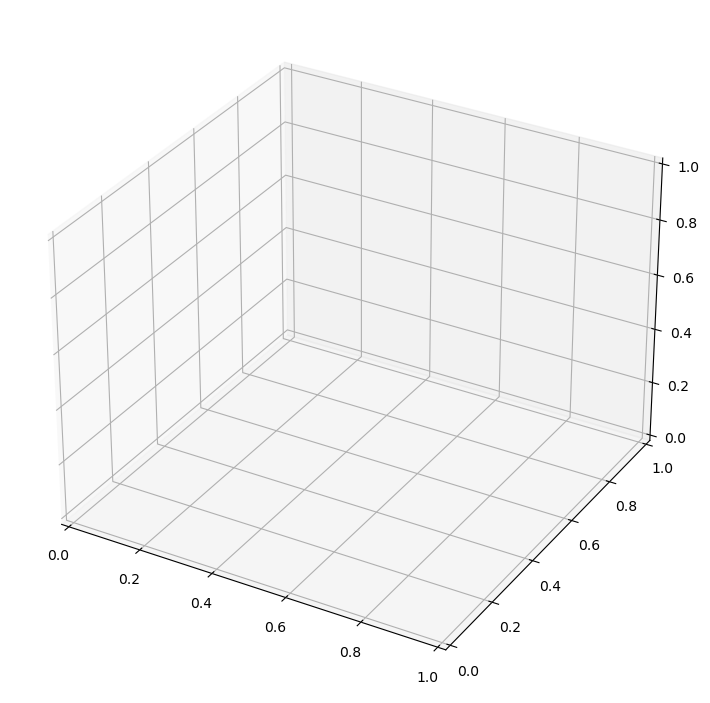

In [15]:
fig = plt.figure(figsize=(30,10))

#%% Plotting Finsler metric 1
ax = fig.add_subplot(131, projection='3d')
plot_sphere = SpherePlot(force_fun=force_fun1)
x1,x2,x3 = plot_sphere.grid(100)
heat_map = plot_sphere.heat_map(x1,x2,x3)
field = plot_sphere.unit_direction(10)
ax.plot_surface(x1, x2, x3, rstride=1, cstride=1, color='cyan', alpha=0.2,
               facecolors=plt.cm.jet(heat_map))
ax.quiver(field[0], field[1], field[2], 
          field[-1][:,:,0], field[-1][:,:,1], field[-1][:,:,2], color='black', length=0.2, normalize=True)
ax.plot(xt_path[:,0], xt_path[:,1], xt_path[:,2], alpha=1.0, color='red')
ax.scatter(xt_path[100,0], xt_path[100,1], xt_path[100,2], alpha=1.0, color='red',s=100)
ax.plot(xt_single[:,0], xt_single[:,1], xt_single[:,2], alpha=1.0, color='blue')
ax.scatter(s2_x0[0], s2_x0[1], s2_x0[2], color='black', alpha=1.0, s=100)
ax.scatter(s2_xT[0], s2_xT[1], s2_xT[2], color='black', alpha=1.0, s=100)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=180., azim=90)

#%% Plotting Finsler metric 2
ax = fig.add_subplot(132, projection='3d')
plot_sphere = SpherePlot(force_fun=force_fun2)
x1,x2,x3 = plot_sphere.grid(100)
heat_map = plot_sphere.heat_map(x1,x2,x3)
field = plot_sphere.unit_direction(10)
ax.plot_surface(x1, x2, x3, rstride=1, cstride=1, color='cyan', alpha=0.2,
               facecolors=plt.cm.jet(heat_map))
ax.quiver(field[0], field[1], field[2], 
          field[-1][:,:,0], field[-1][:,:,1], field[-1][:,:,2], color='black', length=0.2, normalize=True)
ax.plot(xt_path[:,0], xt_path[:,1], xt_path[:,2], alpha=1.0, color='red')
ax.scatter(xt_path[100,0], xt_path[100,1], xt_path[100,2], alpha=1.0, color='red',s=100)
ax.plot(xt_single[:,0], xt_single[:,1], xt_single[:,2], alpha=1.0, color='blue')
ax.scatter(s2_x0[0], s2_x0[1], s2_x0[2], color='black', alpha=1.0, s=100)
ax.scatter(s2_xT[0], s2_xT[1], s2_xT[2], color='black', alpha=1.0, s=100)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=180., azim=90)

#plotting sphere
ax = fig.add_subplot(133)
ax.plot(zt_path[:,0],zt_path[:,1])
ax.plot(zt_single[:,0],zt_single[:,1])
ax.scatter(zt_path[100,0],zt_path[100,1], color='red')
ax.scatter(z0[0],z0[1], color='black')
ax.scatter(zT[0],zT[1], color='black')
ax.grid(True)
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
